In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import gc
import random

import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings(action='ignore')

from pycaret.classification import *

import random as python_random
seed = 42
np.random.seed(seed)
python_random.seed(seed)
set_config('seed', seed)

In [2]:
PATH = './data/'

train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_qua = pd.read_csv(PATH+'train_quality_data.csv')
train_prob = pd.read_csv(PATH+'train_problem_data.csv')

test_err  = pd.read_csv(PATH+'test_err_data.csv')
test_qua  = pd.read_csv(PATH+'test_quality_data.csv')

sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [3]:
def chg_qua(x):
    if x == 0:
        return 0
    else:
        return 1

In [4]:
train_err['date'] = train_err['time'].astype(str).str.slice(0,8)
train_err['model_fwver'] = train_err.model_nm + train_err.fwver
train_err['errtype_code'] = train_err.errtype.astype(str) + train_err.errcode

train_err_0 = train_err[['user_id','date','model_fwver','errtype_code']].drop_duplicates()
display(train_err_0.head())

test_err['date'] = test_err['time'].astype(str).str.slice(0,8)
test_err['model_fwver'] = test_err.model_nm + test_err.fwver
test_err['errtype_code'] = test_err.errtype.astype(str) + test_err.errcode

test_err_0 = test_err[['user_id','date','model_fwver','errtype_code']].drop_duplicates()
display(test_err_0.head())

,user_id,date,model_fwver,errtype_code
0,10000,20201101,model_305.15.2138,151
1,10000,20201101,model_305.15.2138,121
2,10000,20201101,model_305.15.2138,111
3,10000,20201101,model_305.15.2138,161
4,10000,20201101,model_305.15.2138,40


,user_id,date,model_fwver,errtype_code
0,30000,20201101,model_104.16.3553,311
1,30000,20201101,model_104.16.3553,332
2,30000,20201101,model_104.16.3553,151
3,30000,20201101,model_104.16.3553,221
4,30000,20201101,model_104.16.3553,111


In [ ]:
train_err_1 = train_err.groupby(['user_id','date']).count().reset_index()[['user_id','date','time']]
train_err_1.columns = ['user_id','date','date_cnt']
train_err_1 = train_err_1.groupby('user_id').agg({'date':'count','date_cnt': 'sum'}).reset_index()
train_err_1.columns = ['user_id','date_cnt', 'date_sum']
display(train_err_1.head())

test_err_1 = test_err.groupby(['user_id','date']).count().reset_index()[['user_id','date','time']]
test_err_1.columns = ['user_id','date','date_cnt']
test_err_1 = test_err_1.groupby('user_id').agg({'date':'count','date_cnt': 'sum'}).reset_index()
test_err_1.columns = ['user_id','date_cnt', 'date_sum']
display(test_err_1.head())

train_err_1.shape

In [ ]:
train = train_err_1.copy()
test = test_err_1.copy()

In [ ]:
train_model = set(train_err.model_fwver.unique())
test_model = set(test_err.model_fwver.unique())
models = train_model & test_model
models = list(models)

for model in models:
    train[model] = 0
    test[model] = 0
    
train.shape, test.shape    

In [ ]:
train_err_2 = train_err.groupby(['user_id','model_fwver']).count().reset_index()[['user_id','model_fwver','time']]
train_err_2.columns = ['user_id','model_fwver','model_fwver_cnt']
display(train_err_2.head())

test_err_2 = test_err.groupby(['user_id','model_fwver']).count().reset_index()[['user_id','model_fwver','time']]
test_err_2.columns = ['user_id','model_fwver','model_fwver_cnt']
display(test_err_2.head())

In [ ]:
for idx, col in tqdm(enumerate(train_err_2.values)):
    i = train[train.user_id == train_err_2.loc[idx].user_id].index
    c = train.columns[train.columns == train_err_2.loc[idx].model_fwver]
    
    train.loc[i, c] += train_err_2.loc[idx].model_fwver_cnt    

for idx, col in tqdm(enumerate(test_err_2.values)):
    i = test[test.user_id == test_err_2.loc[idx].user_id].index
    c = test.columns[test.columns == test_err_2.loc[idx].model_fwver]
    
    test.loc[i, c] += test_err_2.loc[idx].model_fwver_cnt    

In [ ]:
train_error = set(train_err.errtype.unique())
test_error = set(test_err.errtype.unique())
errors = train_error & test_error
errors = list(errors)

for error in errors:
    train['E'+str(error)] = 0
    test['E'+str(error)] = 0
    
train.shape, test.shape    

In [ ]:
train_err_3 = train_err.groupby(['user_id','errtype']).count().reset_index()[['user_id','errtype','time']]
train_err_3.columns = ['user_id','errtype','errtype_cnt']
display(train_err_3.head())

test_err_3 = test_err.groupby(['user_id','errtype']).count().reset_index()[['user_id','errtype','time']]
test_err_3.columns = ['user_id','errtype','errtype_cnt']
display(test_err_3.head())

In [ ]:
for idx, col in tqdm(enumerate(train_err_3.values)):
    i = train[train.user_id == train_err_3.loc[idx].user_id].index
    c = train.columns[train.columns == 'E'+str(train_err_3.loc[idx].errtype)]
    
    train.loc[i, c] += train_err_3.loc[idx].errtype_cnt    

for idx, col in tqdm(enumerate(test_err_3.values)):
    i = test[test.user_id == test_err_3.loc[idx].user_id].index
    c = test.columns[test.columns == 'E'+str(test_err_3.loc[idx].errtype)]
    
    test.loc[i, c] += test_err_3.loc[idx].errtype_cnt    

In [ ]:
train_qua_0 = train_qua.drop_duplicates()
test_qua_0 = test_qua.drop_duplicates()

train_qua_0.drop(['quality_3','quality_4','time','fwver'], axis=1, inplace=True)
test_qua_0.drop(['quality_3','quality_4','time','fwver'], axis=1, inplace=True)

train_qua_0.fillna(0, inplace=True)
test_qua_0.fillna(0, inplace=True)

In [ ]:
cols = ['quality_0', 'quality_1', 'quality_2', 'quality_5','quality_6', 'quality_7', 'quality_8', 'quality_9', 'quality_10','quality_11', 'quality_12']

for col in cols:
    train_qua_0[col] = train_qua_0[col].apply(chg_qua)
    test_qua_0[col] = test_qua_0[col].apply(chg_qua)

In [ ]:
train_qua_1 = train_qua_0.groupby('user_id').sum().reset_index()
test_qua_1 = test_qua_0.groupby('user_id').sum().reset_index()

In [ ]:
train = train.merge(train_qua_1, on='user_id', how='left').fillna(0)
test = test.merge(test_qua_1, on='user_id', how='left').fillna(0)

In [ ]:
train.to_csv("./train.csv", index=False)
test.to_csv("./test.csv", index=False)

In [5]:
train  = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
display(train.head())
display(test.head())

train.shape, test.shape

,user_id,date_cnt,date_sum,model_403.11.1167,model_804.73.2571,model_004.22.1750,model_610,model_68.5.3,model_204.33.1185,model_705.66.3237,...,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10000,30,317,0,0,0,0,0,0,0,...,0,0,4,0,4,0,4,4,0,0
1,10001,30,2365,0,0,0,0,0,379,0,...,0,0,0,0,0,0,0,0,0,0
2,10002,29,306,0,0,0,0,0,0,0,...,1,2,22,4,22,0,22,22,1,0
3,10003,30,306,0,0,0,0,0,81,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,30,777,0,0,645,0,0,0,0,...,1,1,6,2,6,0,6,6,1,0


,user_id,date_cnt,date_sum,model_403.11.1167,model_804.73.2571,model_004.22.1750,model_610,model_68.5.3,model_204.33.1185,model_705.66.3237,...,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,30000,29,2750,0,0,0,0,0,0,0,...,0,0,2,1,2,0,2,2,0,0
1,30001,28,284,0,0,0,0,0,0,0,...,1,1,10,1,10,0,10,10,1,0
2,30002,30,941,0,0,733,0,0,0,0,...,3,3,26,3,26,0,26,26,3,0
3,30003,28,371,0,0,246,0,0,0,0,...,0,0,13,5,13,0,13,13,0,0
4,30004,30,881,0,0,0,0,0,0,0,...,1,1,5,3,5,0,5,5,1,0


((15000, 86), (14998, 86))

In [7]:
train_err_d1 = train_err.groupby(['user_id','date']).count().groupby('user_id')['time'].max().reset_index()
train_err_d1.columns = ['user_id', 'day_max']
train_err_d1

,user_id,day_max
0,10000,20
1,10001,1452
2,10002,17
3,10003,24
4,10004,102
...,...,...
14995,24995,30
14996,24996,4
14997,24997,64
14998,24998,37


In [8]:
test_err_d1 = test_err.groupby(['user_id','date']).count().groupby('user_id')['time'].max().reset_index()
test_err_d1.columns = ['user_id', 'day_max']
test_err_d1

,user_id,day_max
0,30000,808
1,30001,22
2,30002,67
3,30003,75
4,30004,85
...,...,...
14993,44994,90
14994,44995,35
14995,44996,430
14996,44997,2606


In [9]:
train = train.merge(train_err_d1, on='user_id', how='left')
test = test.merge(test_err_d1, on='user_id', how='left')
train

,user_id,date_cnt,date_sum,model_403.11.1167,model_804.73.2571,model_004.22.1750,model_610,model_68.5.3,model_204.33.1185,model_705.66.3237,...,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,day_max
0,10000,30,317,0,0,0,0,0,0,0,...,0,4,0,4,0,4,4,0,0,20
1,10001,30,2365,0,0,0,0,0,379,0,...,0,0,0,0,0,0,0,0,0,1452
2,10002,29,306,0,0,0,0,0,0,0,...,2,22,4,22,0,22,22,1,0,17
3,10003,30,306,0,0,0,0,0,81,0,...,0,0,0,0,0,0,0,0,0,24
4,10004,30,777,0,0,645,0,0,0,0,...,1,6,2,6,0,6,6,1,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,10,194,0,0,0,0,0,0,0,...,2,6,2,0,0,0,6,2,0,30
14996,24996,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
14997,24997,30,826,0,0,465,0,0,0,0,...,1,8,1,0,0,0,8,1,0,64
14998,24998,21,155,0,0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,37


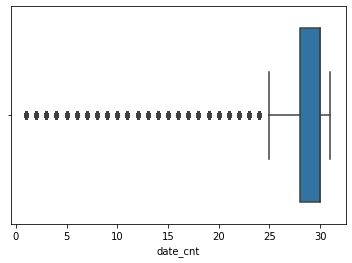

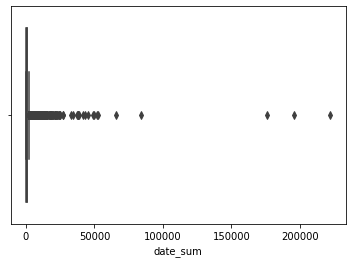

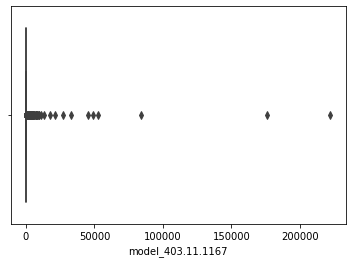

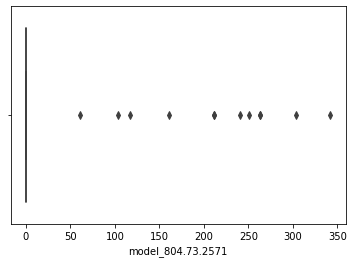

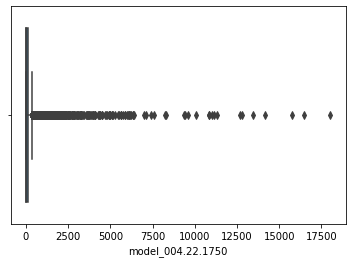

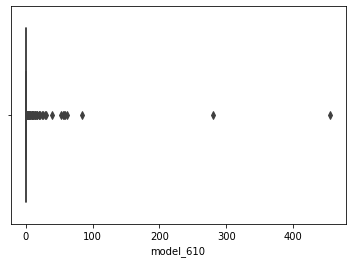

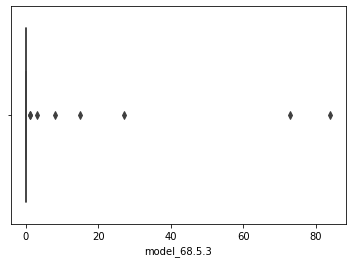

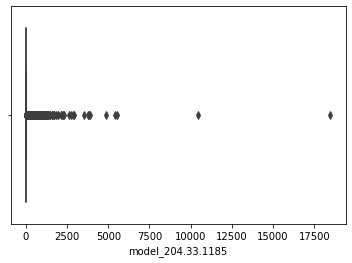

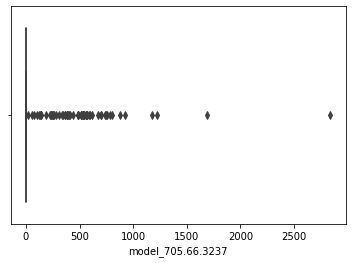

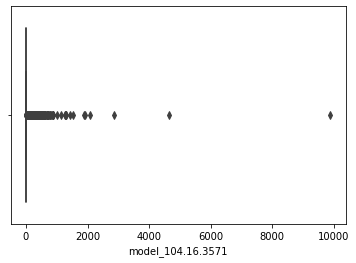

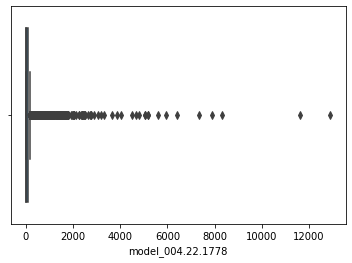

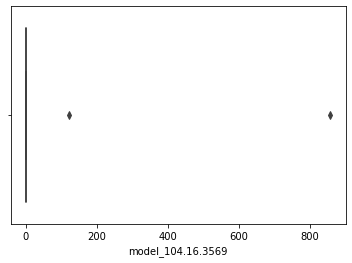

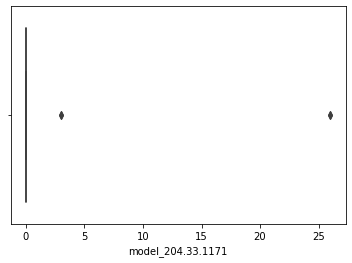

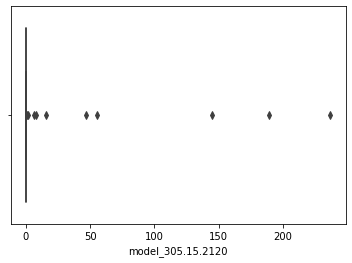

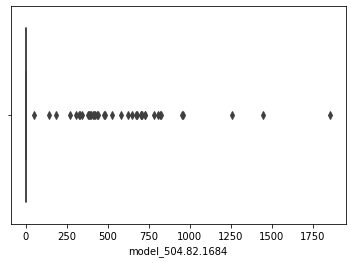

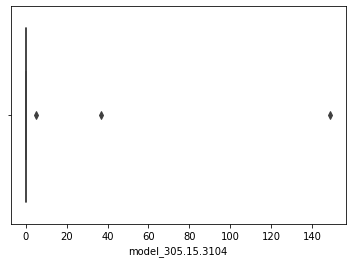

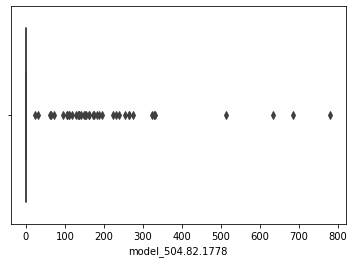

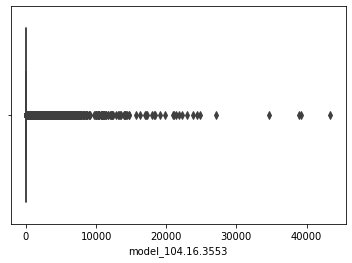

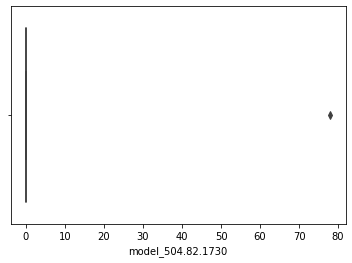

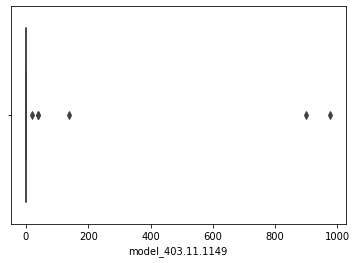

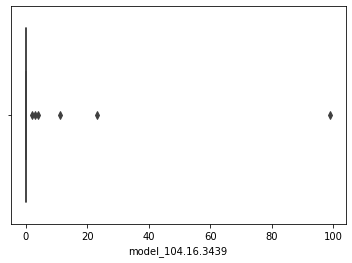

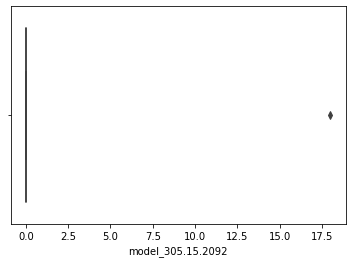

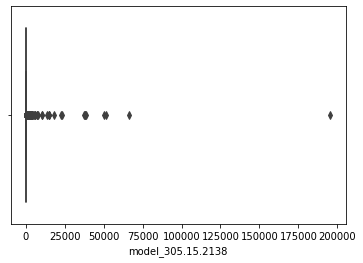

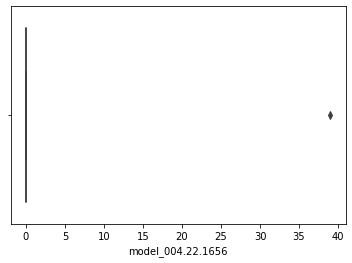

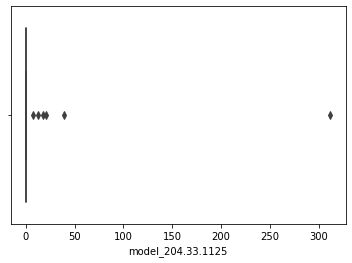

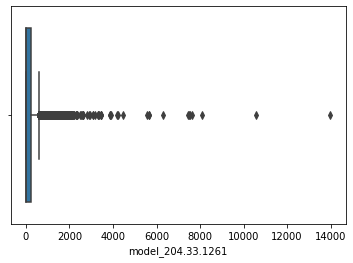

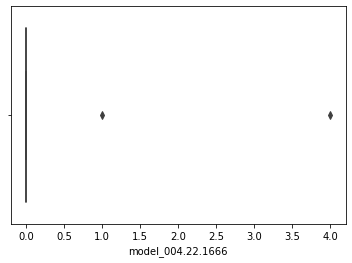

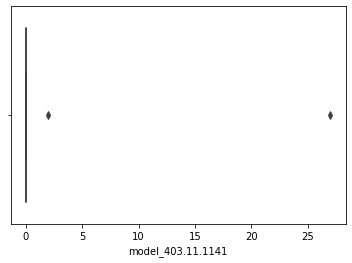

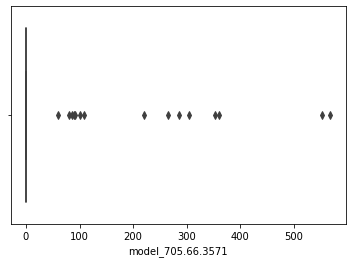

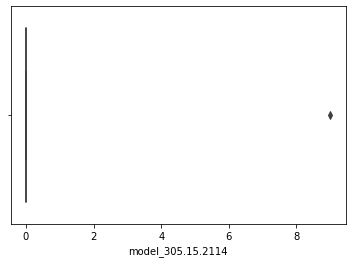

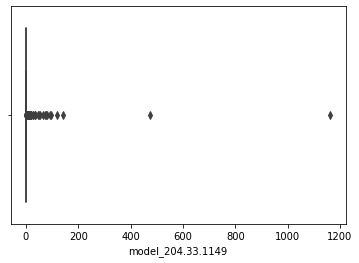

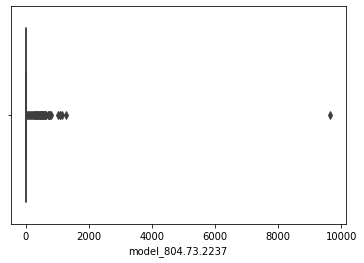

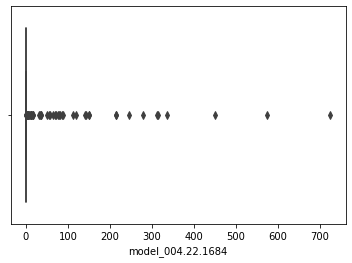

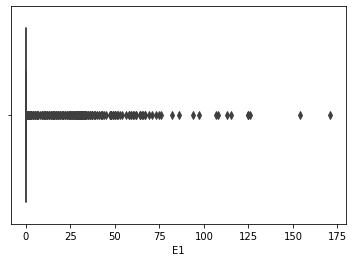

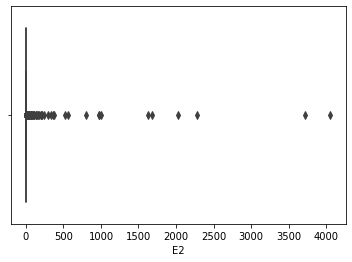

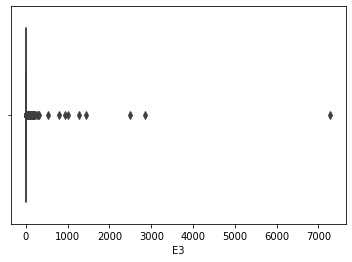

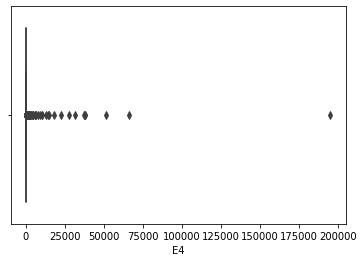

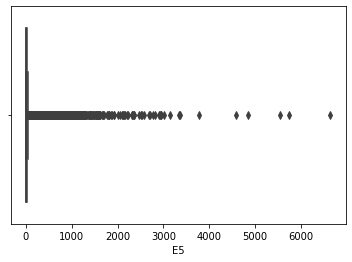

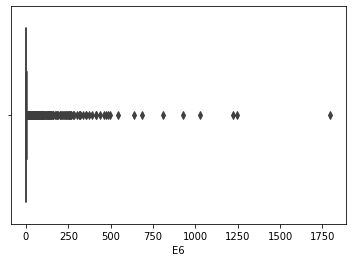

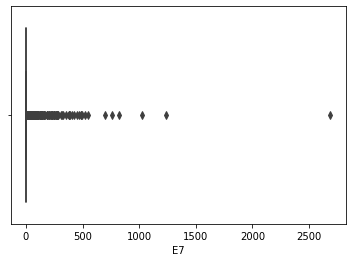

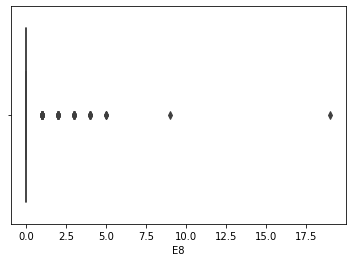

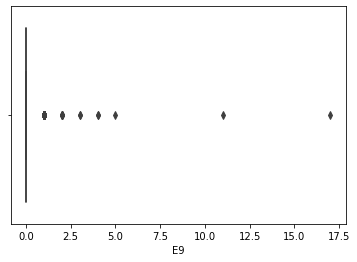

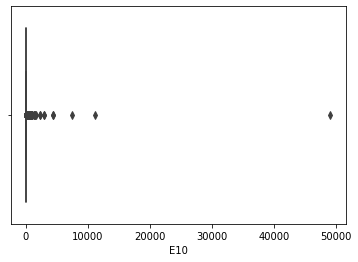

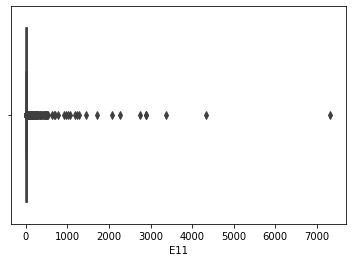

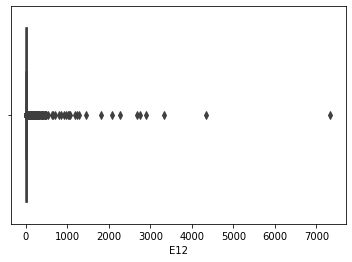

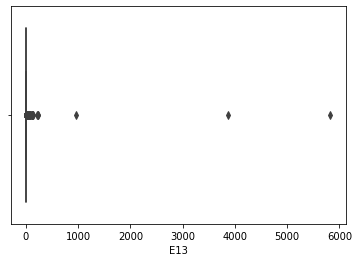

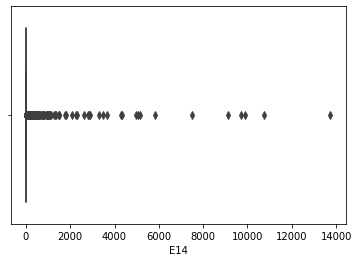

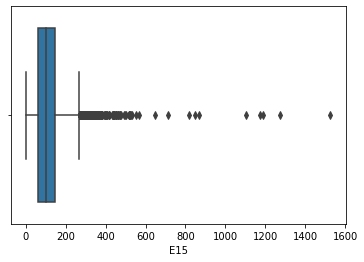

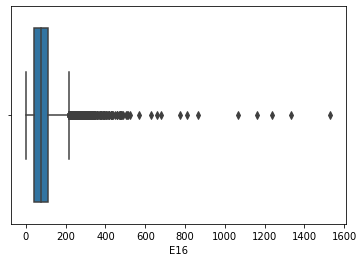

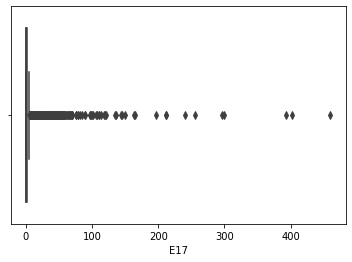

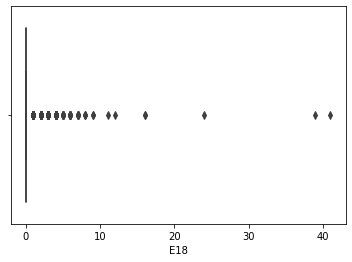

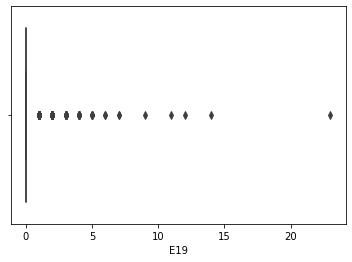

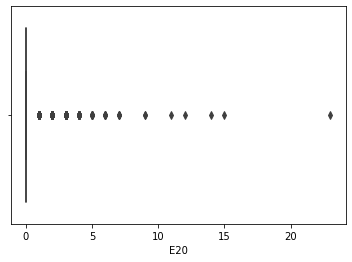

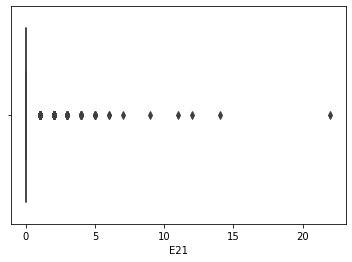

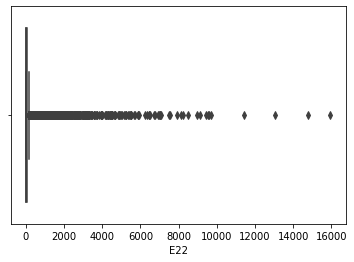

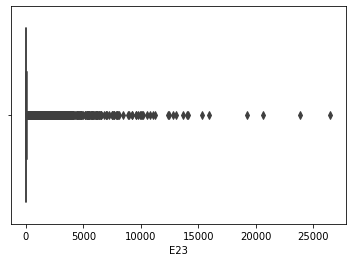

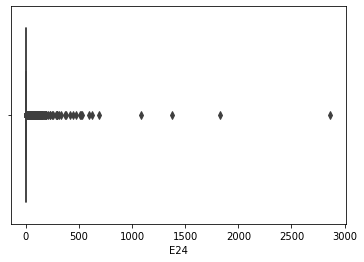

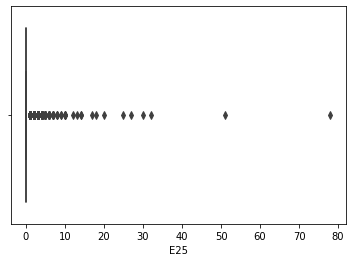

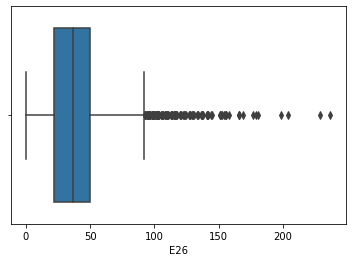

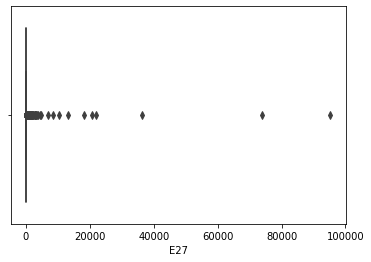

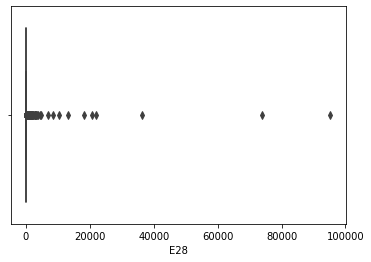

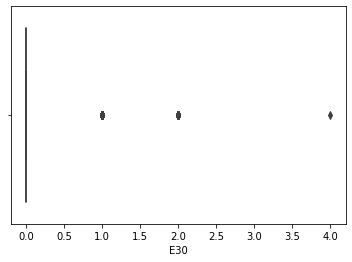

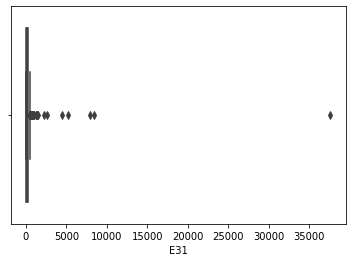

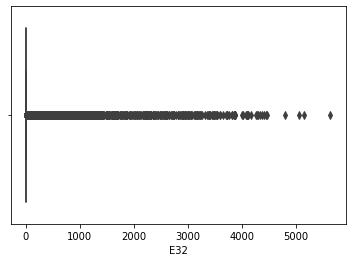

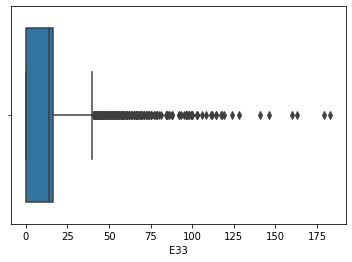

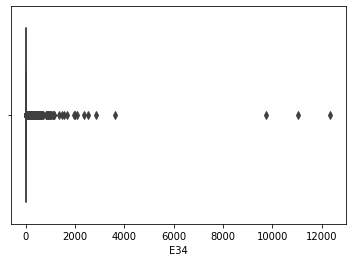

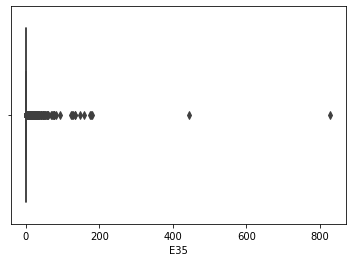

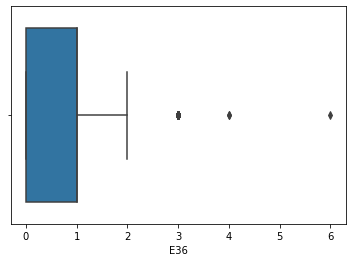

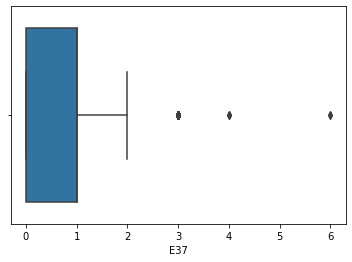

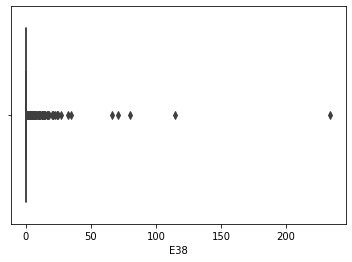

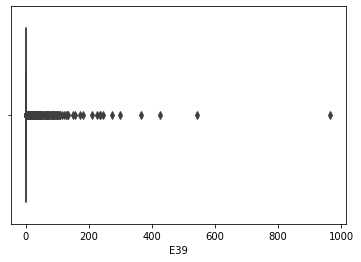

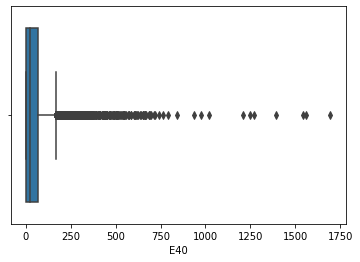

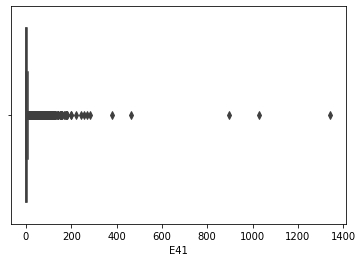

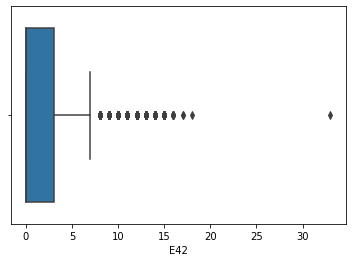

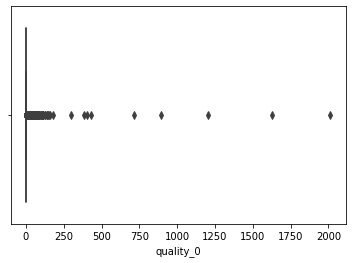

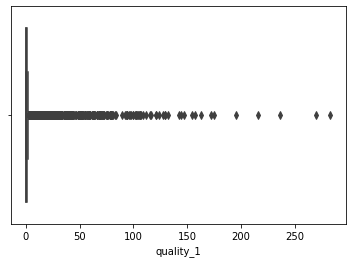

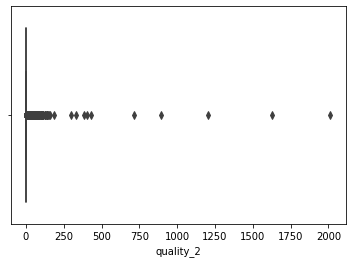

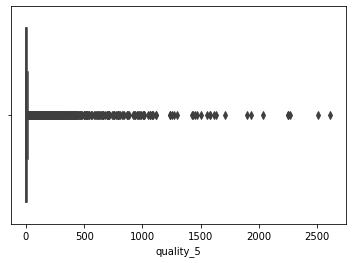

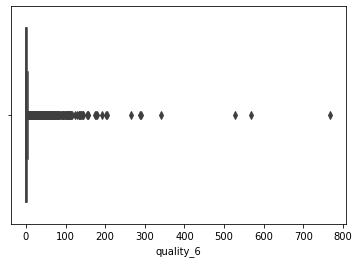

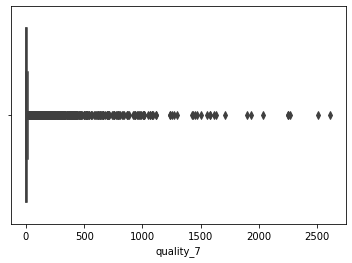

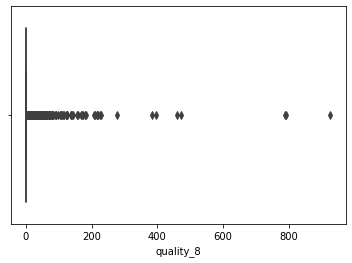

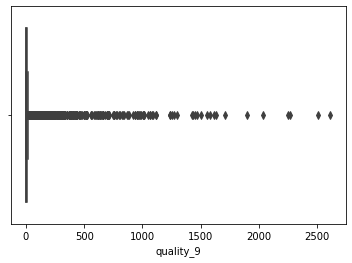

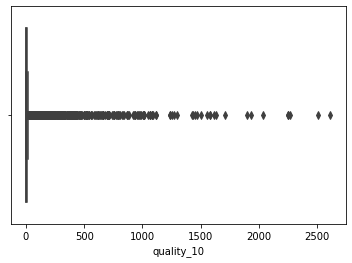

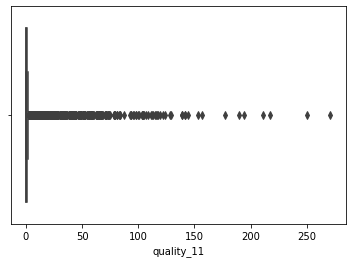

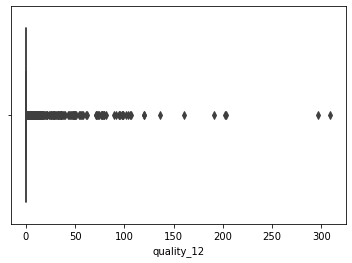

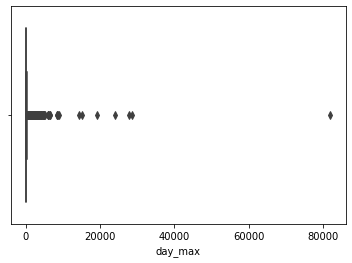

In [12]:
for col in train.iloc[:,1:].columns:
    sns.boxplot(train[col])
    plt.show()

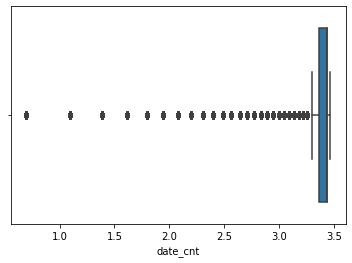

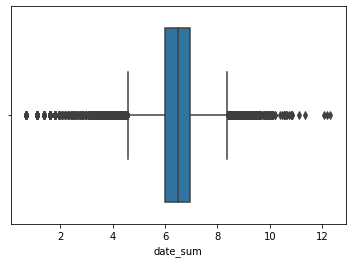

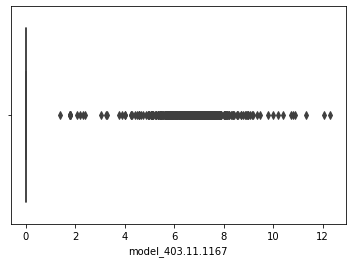

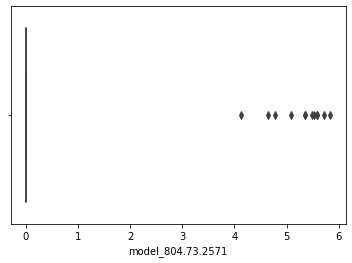

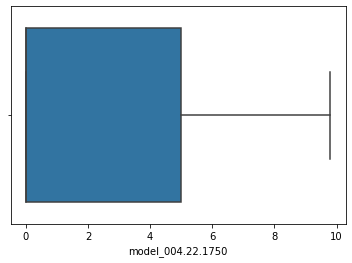

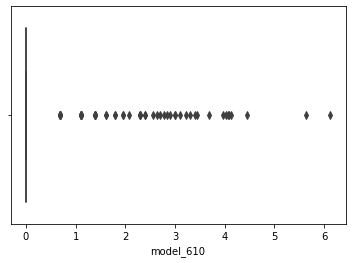

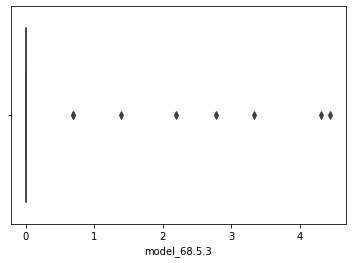

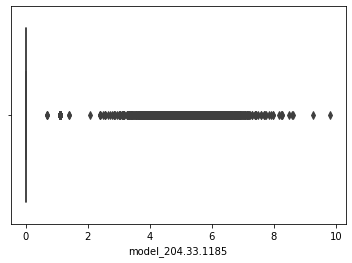

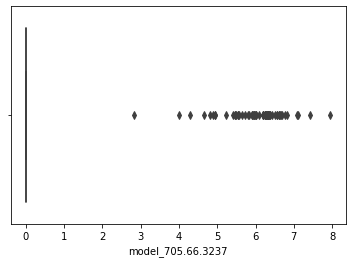

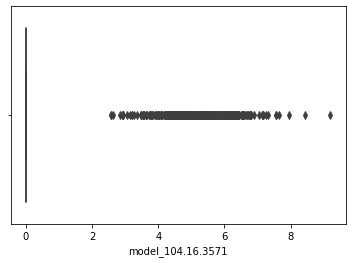

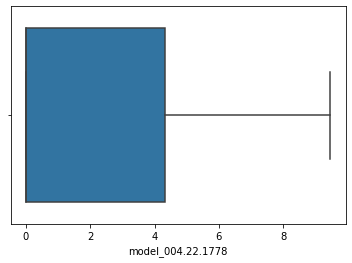

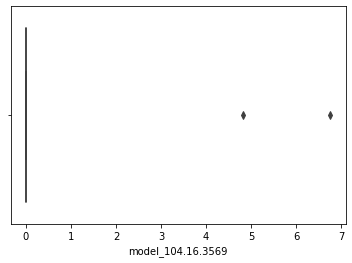

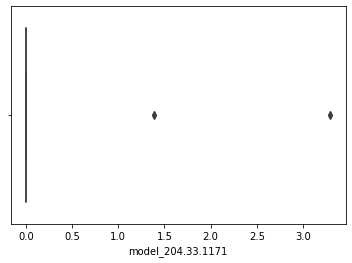

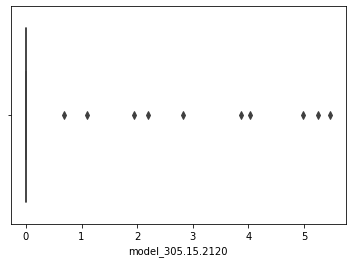

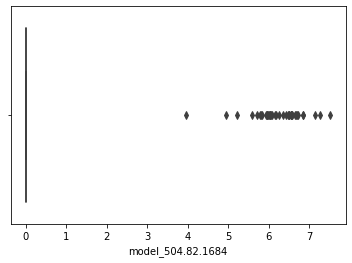

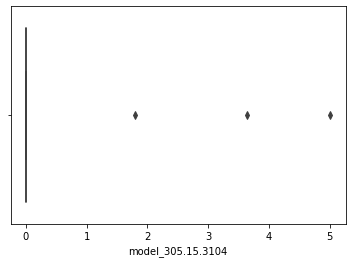

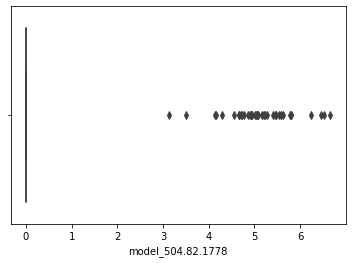

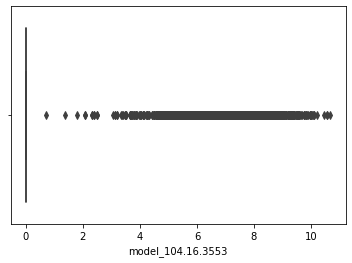

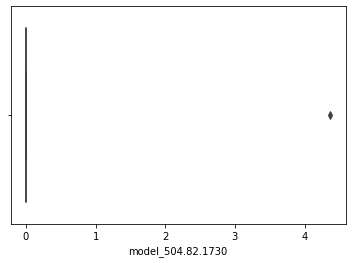

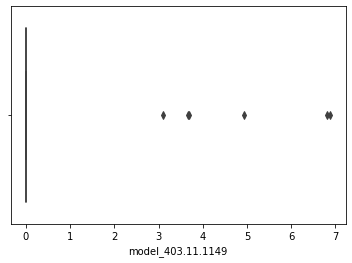

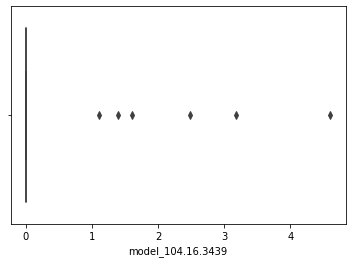

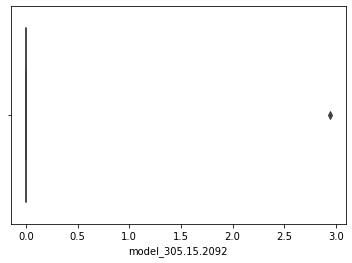

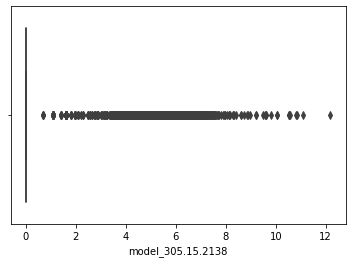

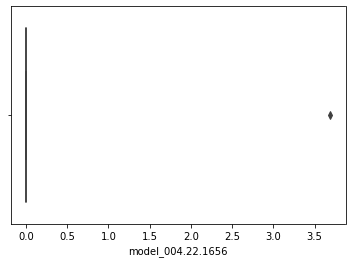

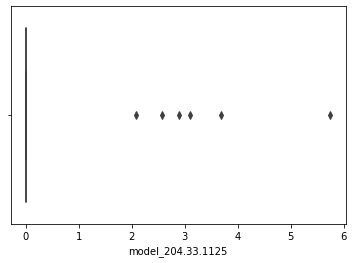

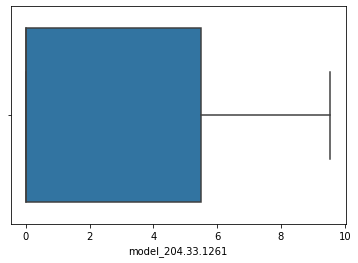

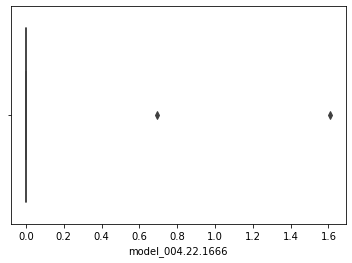

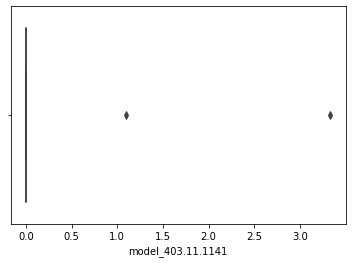

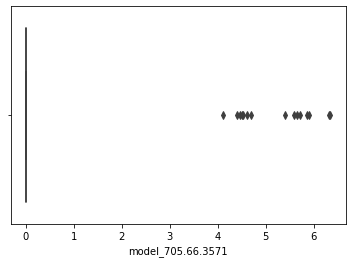

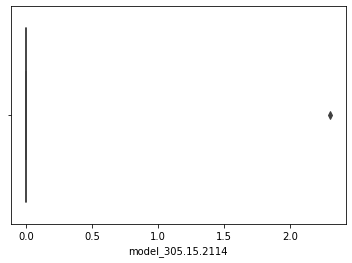

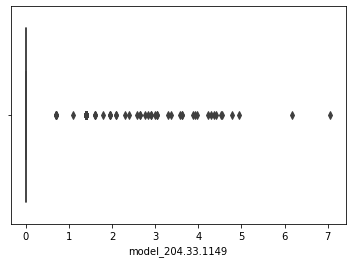

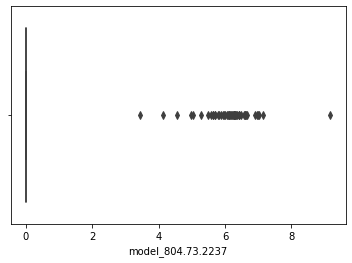

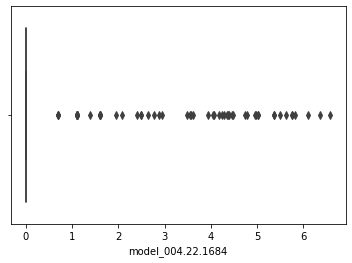

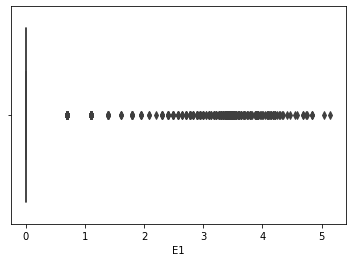

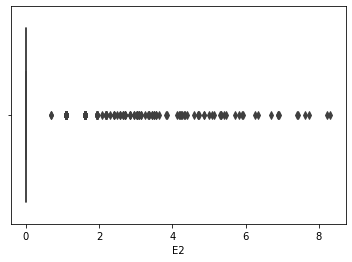

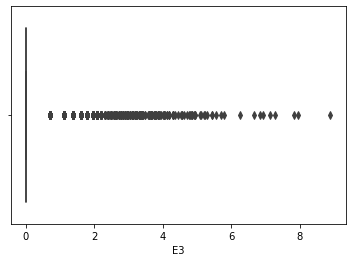

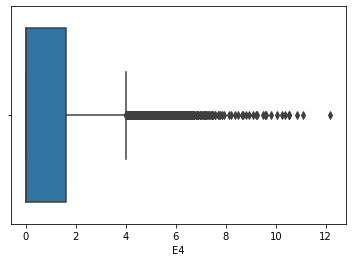

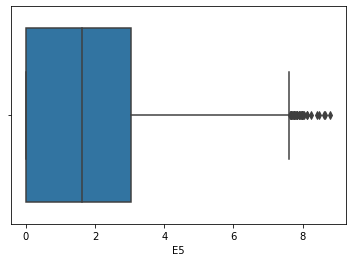

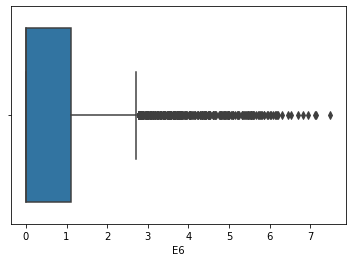

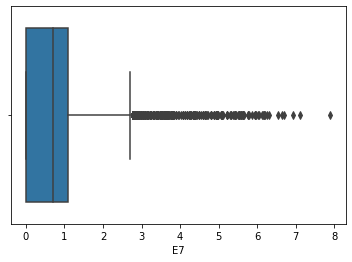

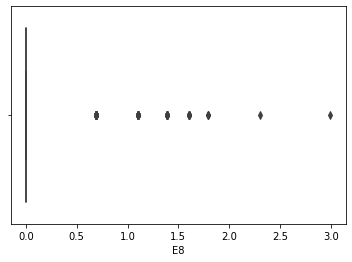

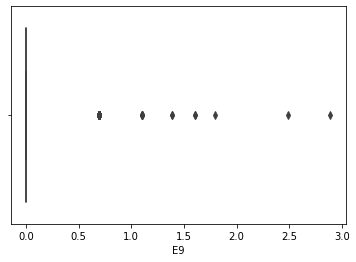

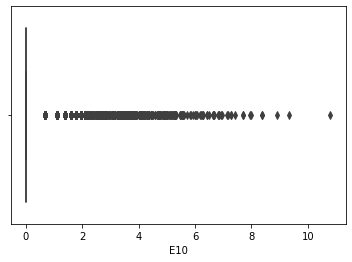

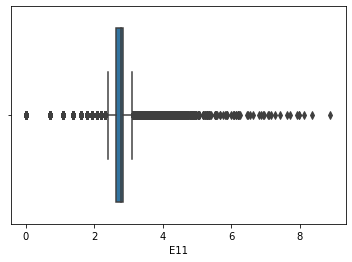

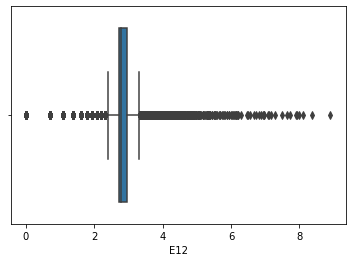

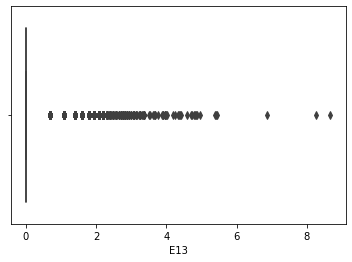

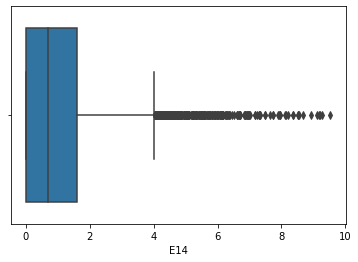

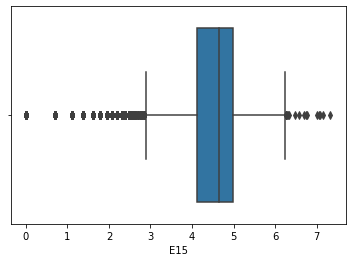

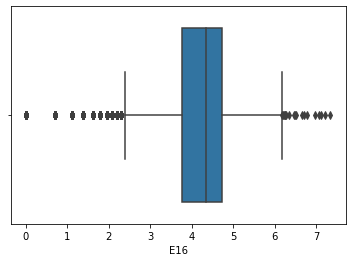

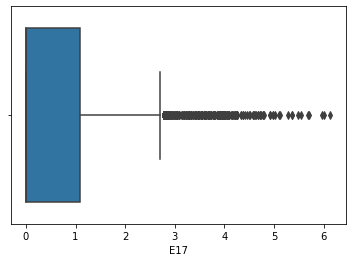

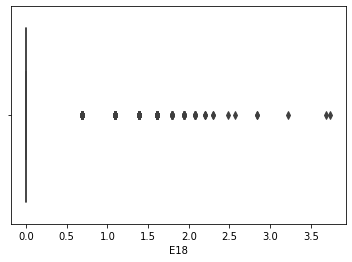

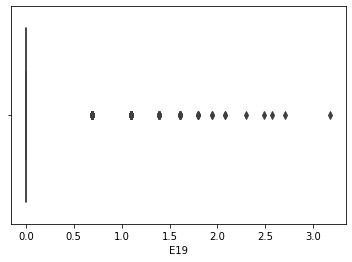

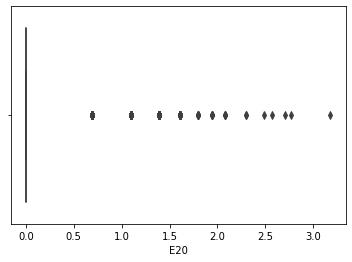

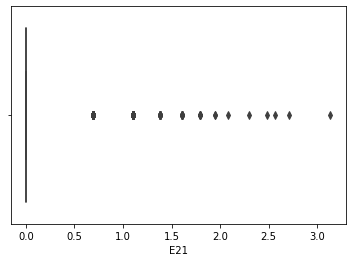

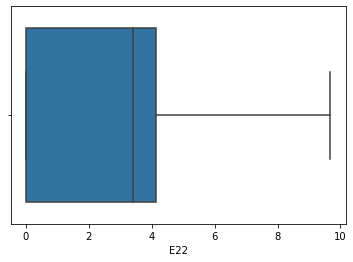

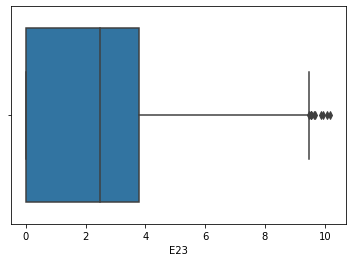

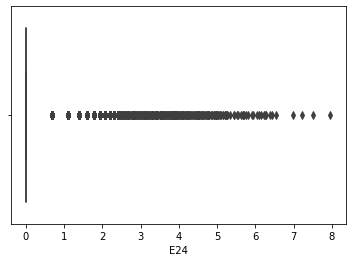

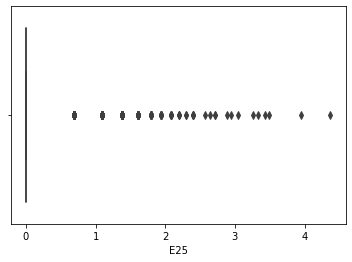

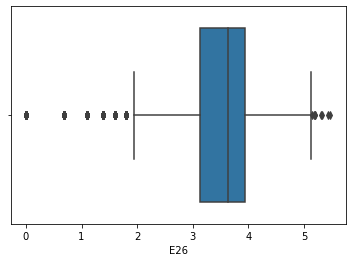

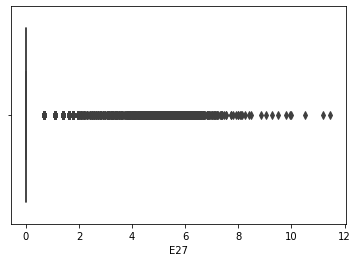

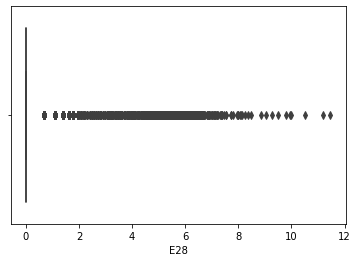

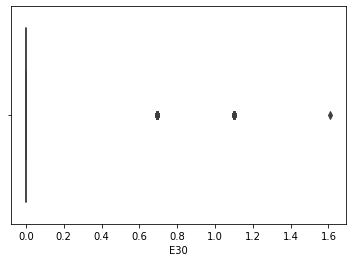

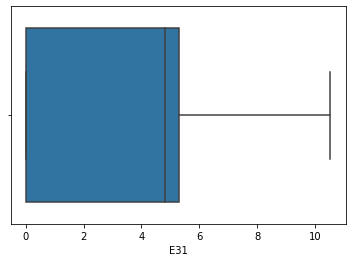

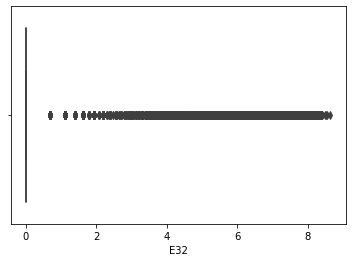

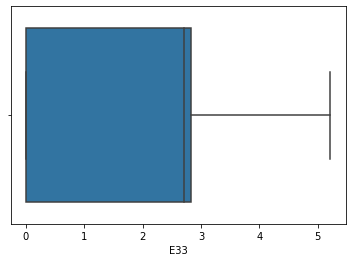

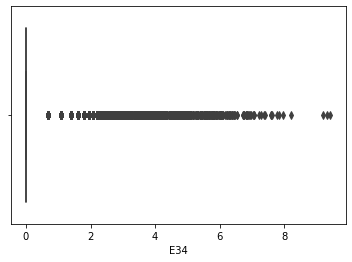

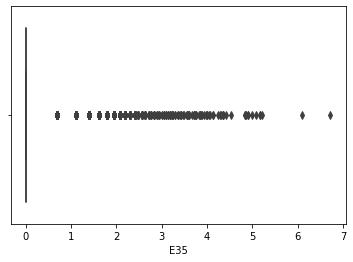

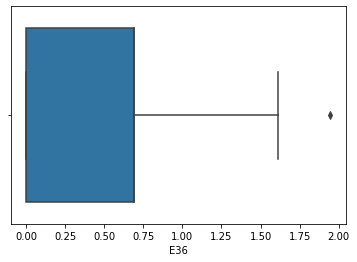

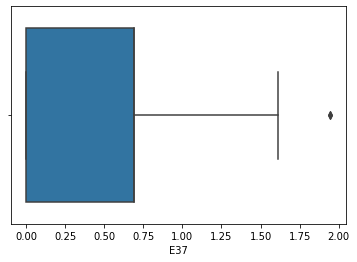

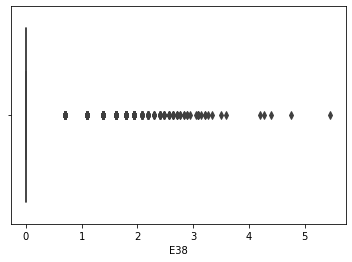

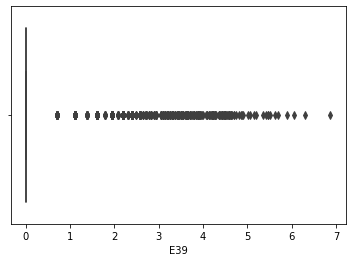

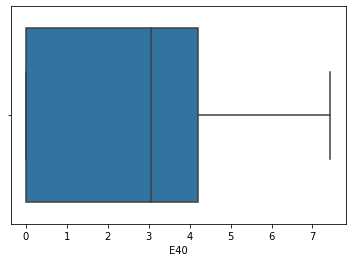

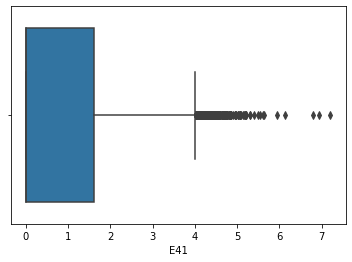

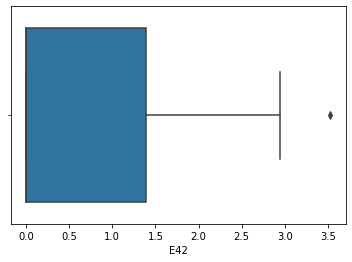

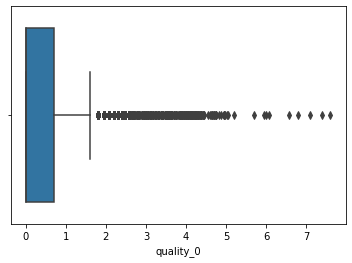

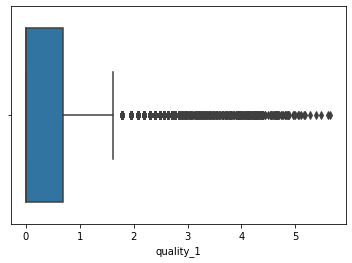

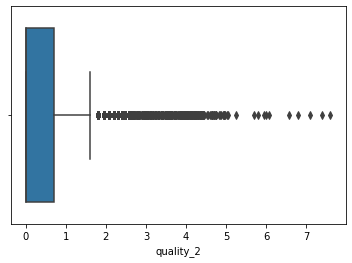

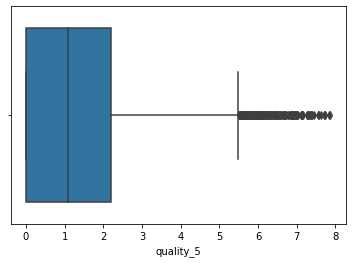

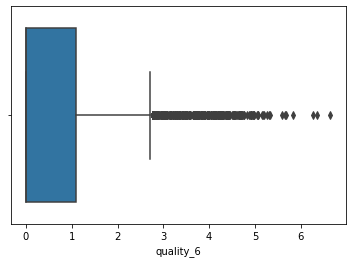

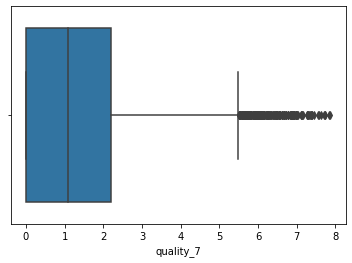

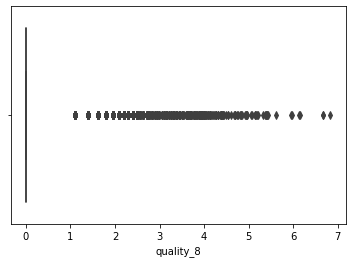

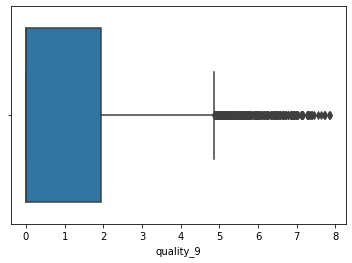

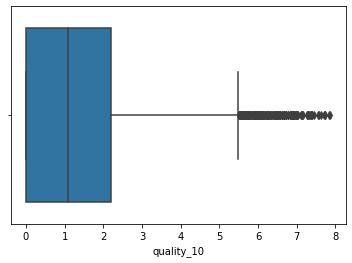

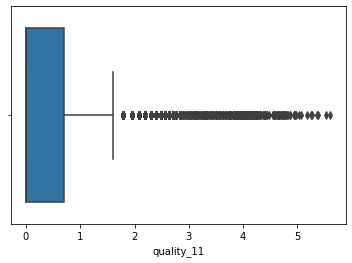

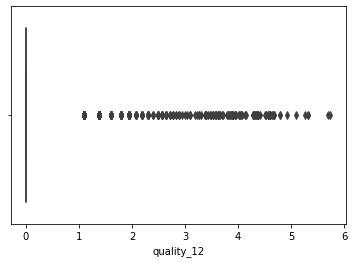

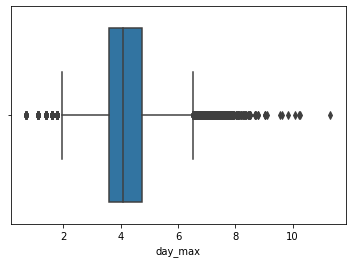

In [13]:
for col in train.iloc[:,1:].columns:
    sns.boxplot(np.log1p(train[col]))
    plt.show()

In [14]:
for col in train.iloc[:,1:].columns:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(train_qua_1.corr(), annot=True, fmt='.2f', cmap='RdYlGn_r')

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='RdYlGn_r')

In [ ]:
test.columns

In [ ]:
train

In [ ]:
test.info()

In [15]:
train_prob1 = train_prob.groupby('user_id').count().reset_index()
train_prob1.time = train_prob1.time.apply(chg_qua)
train_prob1.columns = ['user_id', 'prob']
train_prob1

,user_id,prob
0,10001,1
1,10004,1
2,10005,1
3,10006,1
4,10008,1
...,...,...
4995,24983,1
4996,24984,1
4997,24990,1
4998,24997,1


In [16]:
train = train.merge(train_prob1, on='user_id', how='left').fillna(0)
train

,user_id,date_cnt,date_sum,model_403.11.1167,model_804.73.2571,model_004.22.1750,model_610,model_68.5.3,model_204.33.1185,model_705.66.3237,...,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,day_max,prob
0,10000,3.433987,5.762051,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.609438,0.000000,1.609438,0.0,1.609438,1.609438,0.000000,0.0,3.044522,0.0
1,10001,3.433987,7.768956,0.0,0.0,0.000000,0.0,0.0,5.940171,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,7.281386,1.0
2,10002,3.401197,5.726848,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,3.135494,1.609438,3.135494,0.0,3.135494,3.135494,0.693147,0.0,2.890372,0.0
3,10003,3.433987,5.726848,0.0,0.0,0.000000,0.0,0.0,4.406719,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,3.218876,0.0
4,10004,3.433987,6.656727,0.0,0.0,6.470800,0.0,0.0,0.000000,0.0,...,1.945910,1.098612,1.945910,0.0,1.945910,1.945910,0.693147,0.0,4.634729,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,2.397895,5.273000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.945910,1.098612,0.000000,0.0,0.000000,1.945910,1.098612,0.0,3.433987,0.0
14996,24996,0.693147,1.609438,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.609438,0.0
14997,24997,3.433987,6.717805,0.0,0.0,6.144186,0.0,0.0,0.000000,0.0,...,2.197225,0.693147,0.000000,0.0,0.000000,2.197225,0.693147,0.0,4.174387,1.0
14998,24998,3.091042,5.049856,0.0,0.0,2.197225,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,3.637586,1.0


In [17]:
train.prob = train.prob.astype(int)

In [ ]:
train.info()

In [ ]:
train.columns[1:-1]

In [18]:
%%time
clf = setup(session_id=seed, data=train, target='prob'
           , numeric_features=train.columns[1:-1])

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(15000, 88)"
4,Missing Values,False
5,Numeric Features,87
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 16.6 s


In [19]:
best = compare_models(sort = 'AUC', n_select = 5
                     ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.7949,0.8169,0.5097,0.8038,0.6236,0.4922,0.5165,12.0234
1,Gradient Boosting Classifier,0.7902,0.8154,0.4789,0.8157,0.6032,0.4735,0.5046,3.5489
2,Light Gradient Boosting Machine,0.7904,0.8123,0.5157,0.7813,0.6212,0.4846,0.5046,0.5168
3,Extra Trees Classifier,0.7908,0.8057,0.5011,0.7957,0.6149,0.4814,0.5056,0.5248
4,Linear Discriminant Analysis,0.7844,0.8033,0.4569,0.8148,0.5850,0.4547,0.4896,0.1601
5,Ada Boost Classifier,0.7776,0.7995,0.4849,0.7611,0.5921,0.4495,0.4712,0.9033
6,Extreme Gradient Boosting,0.7822,0.7979,0.5386,0.7371,0.6222,0.4744,0.4860,1.9085
7,Random Forest Classifier,0.7636,0.7677,0.4591,0.7315,0.5640,0.4134,0.4345,0.1264


In [20]:
blended = blend_models(estimator_list = best, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7833,0.8119,0.4671,0.7995,0.5897,0.4560,0.4863
1,0.8081,0.8290,0.5257,0.8383,0.6462,0.5238,0.5507
2,0.7910,0.8224,0.4843,0.8129,0.6070,0.4768,0.5064
3,0.8010,0.8325,0.4843,0.8561,0.6186,0.4976,0.5346
4,0.7842,0.8013,0.4857,0.7852,0.6002,0.4634,0.4885
Mean,0.7935,0.8194,0.4894,0.8184,0.6123,0.4835,0.5133
SD,0.0096,0.0115,0.0194,0.0257,0.0194,0.0246,0.0254


In [21]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7898,0.8195,0.4713,0.8221,0.5992,0.4706,0.504


In [22]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 11s


In [23]:
test_x = sample_submssion[['user_id']].merge(test, on='user_id', how='left').fillna(0)
test_x.shape

(14999, 87)

In [24]:
predictions = predict_model(final_model, data = test_x)

In [25]:
sample_submssion['problem'] = predictions['Score']
sample_submssion.head()

,user_id,problem
0,30000,0.9372
1,30001,0.1715
2,30002,0.3066
3,30003,0.8466
4,30004,0.8595


In [26]:
sample_submssion.to_csv("./submission/submission_20210129-3.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.9372
1,30001,0.1715
2,30002,0.3066
3,30003,0.8466
4,30004,0.8595
...,...,...
14994,44994,0.2820
14995,44995,0.2150
14996,44996,0.6155
14997,44997,0.8564
